In [23]:
import pandas as pd
from prophet import Prophet
import altair as alt

In [200]:
df = pd.read_csv('data_agg_MCC_Month.csv')

In [201]:
df = df.rename(columns={"Amount":"y", "TxnMonth":"ds"})
df = df.sort_values(['MCCGroup', 'ds'])

In [186]:
df.head()

,MCCGroup,ds,y,Nb_Txn
278,Advertising Services,2018-01,57474.22,1498
2642,Advertising Services,2018-02,51618.87,1287
1362,Advertising Services,2018-03,59919.32,1380
3014,Advertising Services,2018-04,58304.21,1418
1429,Advertising Services,2018-05,65877.51,1649


In [87]:
df['MCCGroup'].unique()

array(['Grocery/Bakery/Confectionery', 'Video/Video Streaming Services',
       'Cash/Financial/Insurance/Payment Services',
       'Telecom Equipment/Services', 'Education', 'Parking', 'Airlines',
       'Hotels/Motels/Inns/Resorts', 'Personal Services',
       'Discount Stores', 'Stationery', 'Government Related',
       'Bills and Utilities', 'Bicycles', 'Drug Stores and Pharmacies',
       'Recreation', 'General Merchandise', 'Travel & Tourism',
       'Health and Beauty Shops', 'Online Gaming/Media/Books',
       'Fuel/Service Station', 'Professional Services',
       'Food & Beverage (Restaurants/Bars/Takeaway/Delivery)',
       'Sporting Goods', 'Department Stores', 'Other Business Services',
       'Commercial Equipment', 'Entertainment Leisure',
       'Automotive Services', 'Charity', 'Duty Free Store', 'Storage',
       'Gambling/Betting', 'Clothing & Apparel', 'Antique/Pawn Shops',
       'Music/Computer Stores', 'Tolls', 'Beer & Wine', 'News Stands',
       'Memberships & 

In [178]:
df_single_MCC = df[df['MCCGroup'] == "Hardware Stores and Garden Centres"].copy()

In [179]:
df_single_MCC = df_single_MCC.sort_values('ds')

In [180]:
df_single_MCC['ds'] = pd.to_datetime(df_single_MCC['ds'])

In [181]:
df_single_MCC

,MCCGroup,ds,y,Nb_Txn
2440,Hardware Stores and Garden Centres,2018-01-01,831305.23,11745
255,Hardware Stores and Garden Centres,2018-02-01,725623.55,10786
2727,Hardware Stores and Garden Centres,2018-03-01,1002690.50,13921
141,Hardware Stores and Garden Centres,2018-04-01,1412389.08,18680
1198,Hardware Stores and Garden Centres,2018-05-01,1269924.77,18030
...,...,...,...,...
2089,Hardware Stores and Garden Centres,2022-09-01,1289854.49,15411
2328,Hardware Stores and Garden Centres,2022-10-01,1176791.86,15481
2937,Hardware Stores and Garden Centres,2022-11-01,1175122.39,15436
2299,Hardware Stores and Garden Centres,2022-12-01,1003109.07,14156


In [148]:
def fit_predict_model(dataframe, interval_width = 0.90):
    m = Prophet(yearly_seasonality=True, interval_width = interval_width)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

pred = fit_predict_model(df_single_MCC)

20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing


In [149]:
def detect_anomalies_blogpost(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies_blogpost(pred)

In [199]:
def detect_anomalies_single_MCC(dataframe, interval_width = 0.90):
    m = Prophet(yearly_seasonality=True, interval_width = interval_width)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    forecasted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

In [209]:
def detect_anomalies_all_MCC(dataframe):
    return dataframe.groupby('MCCGroup').apply(detect_anomalies_single_MCC)

In [210]:
result = detect_anomalies_all_MCC(df)
result = result.reset_index('MCCGroup').rename(columns={'ds':'TxnMonth', 'fact':'Amount'})

21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1] done processing
21:37:46 - cmdstanpy - INFO - Chain [1] start processing
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:47 - cmdstanpy - INFO - Chain [1] done processing
21:37:47 - cmdstanpy - INFO - Chain [1] start processing
21:37:47 - cmdstanpy - INFO - Chain [1]

In [211]:
result

ds          yhat    yhat_lower    yhat_upper  \
MCCGroup                                                                       
Advertising Services 0  2018-01-01  57938.962375  45871.200631  70557.141123   
                     1  2018-02-01  59039.523097  46683.916777  71400.106079   
                     2  2018-03-01  62279.051300  50878.935876  75225.163605   
                     3  2018-04-01  63288.521490  50649.026195  75627.550547   
                     4  2018-05-01  70397.399921  57417.836842  82342.409788   
...                            ...           ...           ...           ...   
Wholesale Clubs      56 2022-09-01  45596.010302   2916.627558  91371.935279   
                     57 2022-10-01  22040.656160 -20787.223225  67609.522026   
                     58 2022-11-01  14401.850748 -33126.601388  61458.264767   
                     59 2022-12-01  19776.909726 -26955.007198  66630.777000   
                     60 2023-01-01  13624.697442 -28763.359030  57170.216898   

                             fact  anomaly  importance  
MCCGroup                                                
Advertising Services 0   57474.22        0         0.0  
                     1   51618.87        0         0.0  
                     2   59919.32        0         0.0  
                     3   58304.21        0         0.0  
                     4   65877.51        0         0.0  
...                           ...      ...         ...  
Wholesale Clubs      56  39997.55        0         0.0  
                     57  33020.78        0         0.0  
                     58  23171.54        0         0.0  
                     59  31702.03        0         0.0  
                     60  18167.90        0         0.0  

[3679 rows x 7 columns]

In [219]:
result.to_csv('data_agg_MCC_Month_anomaly.csv', index = False)

In [ ]:
detect_anomalies_all_MCC(df[df['MCCGroup'].isin(['Sporting Goods', 'Hardware Stores and Garden Centres'])])

21:31:06 - cmdstanpy - INFO - Chain [1] start processing
21:31:06 - cmdstanpy - INFO - Chain [1] done processing
21:31:06 - cmdstanpy - INFO - Chain [1] start processing
21:31:06 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower  \
MCCGroup                                                                       
Hardware Stores and Garden Centres 0  2018-01-01  6.443168e+05  4.974713e+05   
                                   1  2018-02-01  6.799422e+05  5.407558e+05   
                                   2  2018-03-01  1.166152e+06  1.028517e+06   
                                   3  2018-04-01  1.359104e+06  1.220408e+06   
                                   4  2018-05-01  1.323321e+06  1.187665e+06   
...                                          ...           ...           ...   
Sporting Goods                     56 2022-09-01  3.613762e+05  3.207716e+05   
                                   57 2022-10-01  3.435618e+05  3.029942e+05   
                                   58 2022-11-01  4.073530e+05  3.676924e+05   
                                   59 2022-12-01  4.061782e+05  3.664256e+05   
                                   60 2023-01-01  4.072530e+05  3.661191e+05   

                                         yhat_upper        fact  anomaly  \
MCCGroup                                                                   
Hardware Stores and Garden Centres 0   7.898732e+05   831305.23        1   
                                   1   8.157299e+05   725623.55        0   
                                   2   1.304143e+06  1002690.50       -1   
                                   3   1.504167e+06  1412389.08        0   
                                   4   1.453099e+06  1269924.77        0   
...                                             ...         ...      ...   
Sporting Goods                     56  4.007716e+05   360563.86        0   
                                   57  3.849458e+05   313646.78        0   
                                   58  4.461068e+05   454521.02        1   
                                   59  4.462825e+05   422841.90        0   
                                   60  4.511633e+05   409663.37        0   

                                       importance  
MCCGroup                                           
Hardware Stores and Garden Centres 0     0.049840  
                                   1     0.000000  
                                   2     0.025758  
                                   3     0.000000  
                                   4     0.000000  
...                                           ...  
Sporting Goods                     56    0.000000  
                                   57    0.000000  
                                   58    0.018512  
                                   59    0.000000  
                                   60    0.000000  

[122 rows x 7 columns]

In [184]:
detect_anomalies_all_MCC(df[df['MCCGroup'].isin(['Sporting Goods', 'Hardware Stores and Garden Centres'])])

21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower  \
MCCGroup                                                                       
Hardware Stores and Garden Centres 0  2018-01-01  6.443168e+05  5.003684e+05   
                                   1  2018-02-01  6.799422e+05  5.343341e+05   
                                   2  2018-03-01  1.166152e+06  1.027239e+06   
                                   3  2018-04-01  1.359104e+06  1.217502e+06   
                                   4  2018-05-01  1.323321e+06  1.194290e+06   
...                                          ...           ...           ...   
Sporting Goods                     56 2022-09-01  3.613762e+05  3.220006e+05   
                                   57 2022-10-01  3.435618e+05  3.049827e+05   
                                   58 2022-11-01  4.073530e+05  3.678329e+05   
                                   59 2022-12-01  4.061782e+05  3.688827e+05   
                                   60 2023-01-01  4.072530e+05  3.700904e+05   

                                         yhat_upper        fact  anomaly  \
MCCGroup                                                                   
Hardware Stores and Garden Centres 0   7.787555e+05  1034826.92        1   
                                   1   8.370580e+05  1412389.08        1   
                                   2   1.306734e+06   725623.55       -1   
                                   3   1.499802e+06  1229486.47        0   
                                   4   1.461292e+06  1236374.63        0   
...                                             ...         ...      ...   
Sporting Goods                     56  4.006436e+05   312782.74       -1   
                                   57  3.813999e+05   369165.63        0   
                                   58  4.471019e+05   299114.08       -1   
                                   59  4.459565e+05   326366.53       -1   
                                   60  4.494069e+05   306397.71       -1   

                                       importance  
MCCGroup                                           
Hardware Stores and Garden Centres 0     0.247453  
                                   1     0.407346  
                                   2     0.415663  
                                   3     0.000000  
                                   4     0.000000  
...                                           ...  
Sporting Goods                     56    0.029470  
                                   57    0.000000  
                                   58    0.229741  
                                   59    0.130271  
                                   60    0.207876  

[122 rows x 7 columns]

In [150]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

In [140]:
pred

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2018-01-01,3.018049e+06,2.516147e+06,2.177914e+06,2.868623e+06,2407262.24,0,0.0
1,2018-02-01,2.991722e+06,2.549452e+06,2.219331e+06,2.889026e+06,2310975.94,0,0.0
2,2018-03-01,2.967943e+06,2.722505e+06,2.364070e+06,3.094437e+06,2577969.14,0,0.0
3,2018-04-01,2.941616e+06,2.735066e+06,2.394126e+06,3.083989e+06,2708168.36,0,0.0
4,2018-05-01,2.916139e+06,2.961098e+06,2.623885e+06,3.328658e+06,3065445.72,0,0.0
...,...,...,...,...,...,...,...,...
56,2022-09-01,2.860001e+06,3.095913e+06,2.762983e+06,3.458419e+06,3058403.28,0,0.0
57,2022-10-01,2.888911e+06,3.115410e+06,2.783058e+06,3.468199e+06,3039796.90,0,0.0
58,2022-11-01,2.918783e+06,2.853544e+06,2.507684e+06,3.182601e+06,2785560.46,0,0.0
59,2022-12-01,2.947692e+06,2.680906e+06,2.337964e+06,3.044113e+06,2423197.69,0,0.0


In [ ]:
df_single_MCC

In [51]:
import seaborn as sns

<AxesSubplot:xlabel='ds', ylabel='y'>

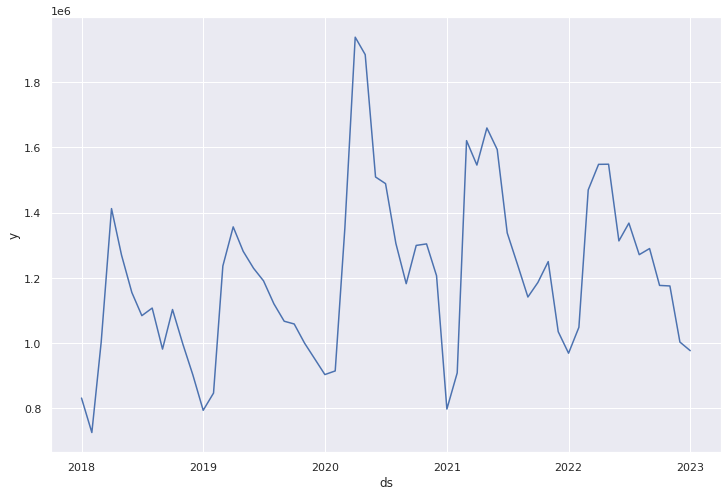

In [190]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=df_single_MCC['ds'], y=df_single_MCC['y'])

In [194]:
# Add seasonality
model = Prophet(interval_width=0.90, yearly_seasonality=True)# Fit the model on the training dataset
model.fit(df_single_MCC)

21:33:07 - cmdstanpy - INFO - Chain [1] start processing
21:33:08 - cmdstanpy - INFO - Chain [1] done processing


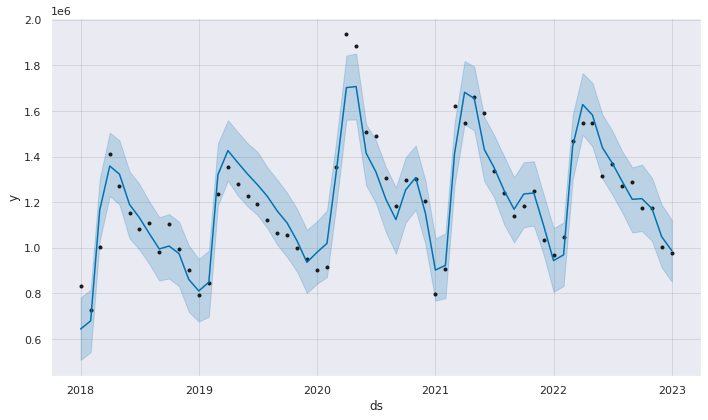

In [195]:
# Make prediction
forecast = model.predict(df_single_MCC)# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

In [196]:
forecast['fact'] = df_single_MCC['y'].reset_index(drop = True)

In [197]:
forecast['MCCGroup'] = df_single_MCC['MCCGroup'].reset_index(drop = True)

In [198]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact,MCCGroup
0,2018-01-01,1.016146e+06,5.082507e+05,7.821158e+05,1.016146e+06,1.016146e+06,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,0.0,0.0,0.0,6.443168e+05,831305.23,Hardware Stores and Garden Centres
1,2018-02-01,1.026438e+06,5.430458e+05,8.168014e+05,1.026438e+06,1.026438e+06,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,0.0,0.0,0.0,6.799422e+05,725623.55,Hardware Stores and Garden Centres
2,2018-03-01,1.035733e+06,1.031877e+06,1.302524e+06,1.035733e+06,1.035733e+06,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,0.0,0.0,0.0,1.166152e+06,1002690.50,Hardware Stores and Garden Centres
3,2018-04-01,1.046025e+06,1.227950e+06,1.505611e+06,1.046025e+06,1.046025e+06,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,0.0,0.0,0.0,1.359104e+06,1412389.08,Hardware Stores and Garden Centres
4,2018-05-01,1.055985e+06,1.189725e+06,1.470669e+06,1.055985e+06,1.055985e+06,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,0.0,0.0,0.0,1.323321e+06,1269924.77,Hardware Stores and Garden Centres
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2022-09-01,1.314700e+06,1.067544e+06,1.352941e+06,1.314700e+06,1.314700e+06,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,0.0,0.0,0.0,1.212987e+06,1289854.49,Hardware Stores and Garden Centres
57,2022-10-01,1.314521e+06,1.073836e+06,1.364980e+06,1.314521e+06,1.314521e+06,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,0.0,0.0,0.0,1.216002e+06,1176791.86,Hardware Stores and Garden Centres
58,2022-11-01,1.314336e+06,1.029824e+06,1.306953e+06,1.314336e+06,1.314336e+06,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,0.0,0.0,0.0,1.172366e+06,1175122.39,Hardware Stores and Garden Centres
59,2022-12-01,1.314158e+06,9.146548e+05,1.188994e+06,1.314158e+06,1.314158e+06,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,0.0,0.0,0.0,1.048840e+06,1003109.07,Hardware Stores and Garden Centres


In [193]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,1.016146e+06,4.912834e+05,7.774856e+05,1.016146e+06,1.016146e+06,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,0.0,0.0,0.0,6.443168e+05
1,2018-02-01,1.026438e+06,5.417758e+05,8.129875e+05,1.026438e+06,1.026438e+06,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,0.0,0.0,0.0,6.799422e+05
2,2018-03-01,1.035733e+06,1.035426e+06,1.308786e+06,1.035733e+06,1.035733e+06,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,0.0,0.0,0.0,1.166152e+06
3,2018-04-01,1.046025e+06,1.232864e+06,1.507875e+06,1.046025e+06,1.046025e+06,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,0.0,0.0,0.0,1.359104e+06
4,2018-05-01,1.055985e+06,1.185957e+06,1.462313e+06,1.055985e+06,1.055985e+06,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,0.0,0.0,0.0,1.323321e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2022-09-01,1.314700e+06,1.073022e+06,1.346929e+06,1.314700e+06,1.314700e+06,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,0.0,0.0,0.0,1.212987e+06
57,2022-10-01,1.314521e+06,1.068277e+06,1.360967e+06,1.314521e+06,1.314521e+06,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,0.0,0.0,0.0,1.216002e+06
58,2022-11-01,1.314336e+06,1.033425e+06,1.305522e+06,1.314336e+06,1.314336e+06,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,0.0,0.0,0.0,1.172366e+06
59,2022-12-01,1.314158e+06,9.100532e+05,1.189028e+06,1.314158e+06,1.314158e+06,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,0.0,0.0,0.0,1.048840e+06


In [170]:
df_single_MCC['y'].reset_index(drop = True)

0      831305.23
1      725623.55
2     1002690.50
3     1412389.08
4     1269924.77
         ...    
56    1289854.49
57    1176791.86
58    1175122.39
59    1003109.07
60     976663.64
Name: y, Length: 61, dtype: float64

In [171]:
df_single_MCC['y']

2440     831305.23
255      725623.55
2727    1002690.50
141     1412389.08
1198    1269924.77
           ...    
2089    1289854.49
2328    1176791.86
2937    1175122.39
2299    1003109.07
638      976663.64
Name: y, Length: 61, dtype: float64

In [169]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,fact
0,2018-01-01,1.016146e+06,5.133130e+05,7.901868e+05,1.016146e+06,1.016146e+06,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,0.0,0.0,0.0,6.443168e+05,831305.23
1,2018-02-01,1.026438e+06,5.362292e+05,8.240546e+05,1.026438e+06,1.026438e+06,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,0.0,0.0,0.0,6.799422e+05,725623.55
2,2018-03-01,1.035733e+06,1.016048e+06,1.303064e+06,1.035733e+06,1.035733e+06,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,0.0,0.0,0.0,1.166152e+06,1002690.50
3,2018-04-01,1.046025e+06,1.223670e+06,1.501999e+06,1.046025e+06,1.046025e+06,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,0.0,0.0,0.0,1.359104e+06,1412389.08
4,2018-05-01,1.055985e+06,1.186621e+06,1.462538e+06,1.055985e+06,1.055985e+06,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,0.0,0.0,0.0,1.323321e+06,1269924.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2022-09-01,1.314700e+06,1.073863e+06,1.352590e+06,1.314700e+06,1.314700e+06,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,0.0,0.0,0.0,1.212987e+06,1289854.49
57,2022-10-01,1.314521e+06,1.073109e+06,1.350780e+06,1.314521e+06,1.314521e+06,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,0.0,0.0,0.0,1.216002e+06,1176791.86
58,2022-11-01,1.314336e+06,1.026421e+06,1.316673e+06,1.314336e+06,1.314336e+06,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,0.0,0.0,0.0,1.172366e+06,1175122.39
59,2022-12-01,1.314158e+06,9.102374e+05,1.182628e+06,1.314158e+06,1.314158e+06,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,0.0,0.0,0.0,1.048840e+06,1003109.07


In [166]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,1.016146e+06,5.133130e+05,7.901868e+05,1.016146e+06,1.016146e+06,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,-371829.223561,0.0,0.0,0.0,6.443168e+05
1,2018-02-01,1.026438e+06,5.362292e+05,8.240546e+05,1.026438e+06,1.026438e+06,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,-346495.576964,0.0,0.0,0.0,6.799422e+05
2,2018-03-01,1.035733e+06,1.016048e+06,1.303064e+06,1.035733e+06,1.035733e+06,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,130418.396151,0.0,0.0,0.0,1.166152e+06
3,2018-04-01,1.046025e+06,1.223670e+06,1.501999e+06,1.046025e+06,1.046025e+06,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,313078.757322,0.0,0.0,0.0,1.359104e+06
4,2018-05-01,1.055985e+06,1.186621e+06,1.462538e+06,1.055985e+06,1.055985e+06,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,267336.604443,0.0,0.0,0.0,1.323321e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2022-09-01,1.314700e+06,1.073863e+06,1.352590e+06,1.314700e+06,1.314700e+06,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,-101712.773133,0.0,0.0,0.0,1.212987e+06
57,2022-10-01,1.314521e+06,1.073109e+06,1.350780e+06,1.314521e+06,1.314521e+06,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,-98518.833036,0.0,0.0,0.0,1.216002e+06
58,2022-11-01,1.314336e+06,1.026421e+06,1.316673e+06,1.314336e+06,1.314336e+06,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,-141970.716593,0.0,0.0,0.0,1.172366e+06
59,2022-12-01,1.314158e+06,9.102374e+05,1.182628e+06,1.314158e+06,1.314158e+06,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,-265317.414710,0.0,0.0,0.0,1.048840e+06
